In [1]:
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
def preprocess(df):
    """ Preprocess the Data, making the data in percentage"""
    for prop in ["employment_rate", "prop_educ_college_educ"]:
        df[prop] *= 100
        
    return df
    

def viz(df, var, indep_var, log):  # TODO: Add titile and axis info
    """ Visualize perc_tech50_avail with a dependent variable
    
    Params:
        df (dataframe)
        var (str): name of the dependent variable
        indep_var (str): name of the independent variable
        log (bool): whether to use log(var)
    """    
    plt.figure(figsize=(13,9))
    if not log:        
        plt.scatter(df[indep_var], df[var], s=2, alpha=0.05)
        plt.show()
    else:
        df["log_"+var] = np.log(df[var])
        plt.scatter(df[indep_var], df["log_"+var], s=2, alpha=0.05)
        plt.show()

        
def mix_model(df, var, indep_var):
    """ Fit a linear mixed model: var ~ indep_var
    
    Params:
        df (dataframe)
        var (str): name of the dependent variable  
        indep_var (str): name of the independent variable
    """
    md = smf.mixedlm(var+" ~ "+ indep_var,
                 df[df[var].notnull()],
                 groups=df[df[var].notnull()]["block_group_code"])
    mdf = md.fit()
    return mdf        

In [0]:
list_var = [
    "median_home_value",
    "employment_rate",
    "prop_educ_college_educ" 
]

list_prop = [
    "employment_rate",
    "prop_educ_college_educ"
]

list_log = [
    "median_home_value"
]

args_list = [
    (">= 0.8", "IN"),
    ("<= 0.2", "IN"),
    (">= 0.8", "NOT IN"),
    ("<= 0.2", "NOT IN")
]

# Fiber Access Rate (As a continous variable)

In [0]:
query_temp = """
SELECT block_group_code, employment_rate, prop_educ_college_educ, median_home_value, population_density, perc_tech50_avail
FROM broadband.fcc_acs_with_geo_and_props_2014_table
WHERE median_home_value > 0 AND perc_urban {0} AND block_group_code {1} (SELECT block_group_code FROM broadband.blockgroup_obtain_fiber)

UNION ALL

SELECT block_group_code, employment_rate, prop_educ_college_educ, median_home_value, population_density, perc_tech50_avail
FROM broadband.fcc_acs_with_geo_and_props_2015_table
WHERE median_home_value > 0 AND perc_urban {0} AND block_group_code {1} (SELECT block_group_code FROM broadband.blockgroup_obtain_fiber)

UNION ALL

SELECT block_group_code, employment_rate, prop_educ_college_educ, median_home_value, population_density, perc_tech50_avail
FROM broadband.fcc_acs_with_geo_and_props_2016_table
WHERE median_home_value > 0 AND perc_urban {0} AND block_group_code {1} (SELECT block_group_code FROM broadband.blockgroup_obtain_fiber)
"""

In [0]:
df = pd.read_gbq(query_temp.format(">= 0.8", "IN"), project_id='fccdsicapstone-218522', dialect='standard')
df = preprocess(df)
smf.stats.anova_lm()

In [9]:
anova_lm

<function statsmodels.stats.anova.anova_lm>

### Urban, Obtain Fiber

median_home_value


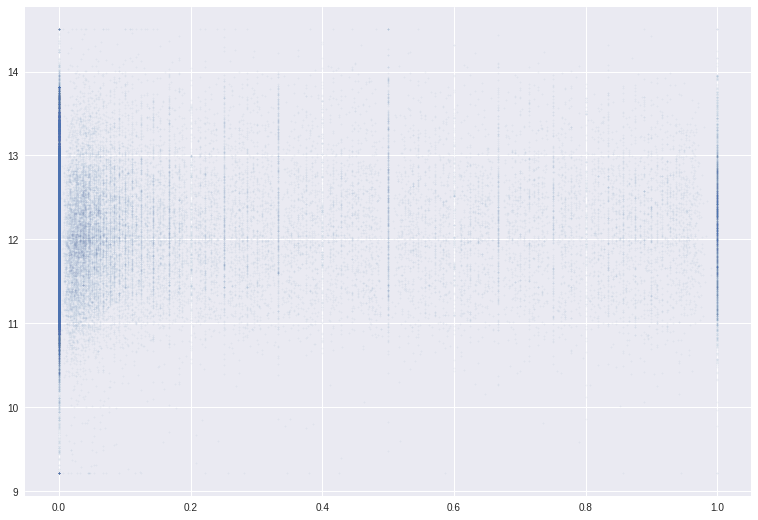

AttributeError: ignored

In [11]:
df = pd.read_gbq(query_temp.format(">= 0.8", "IN"), project_id='fccdsicapstone-218522', dialect='standard')
df = preprocess(df)
for var in list_var:    
    print(var)
    viz(df, var, "perc_tech50_avail", var in list_log)
    model = mix_model(df, var, "perc_tech50_avail")
    table = anova_lm(model, type=2)
    print(model.summary())
    print(table)

### Rural, Obtain Fiber

median_home_value


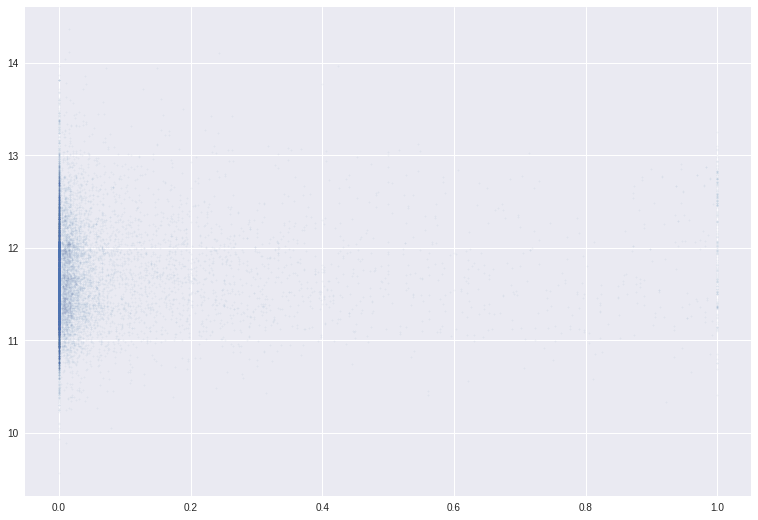

                    Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      median_home_value
No. Observations:      15653        Method:                  REML             
No. Groups:            5274         Scale:                   309037412.1553   
Min. group size:       1            Likelihood:              -186937.4722     
Max. group size:       3            Converged:               Yes              
Mean group size:       3.0                                                    
------------------------------------------------------------------------------
                      Coef.       Std.Err.    z    P>|z|   [0.025     0.975]  
------------------------------------------------------------------------------
Intercept             141250.474  1306.767 108.092 0.000 138689.258 143811.689
perc_tech50_avail       6974.847  1120.062   6.227 0.000   4779.566   9170.129
groups RE         8877531127.204 12225.313                               

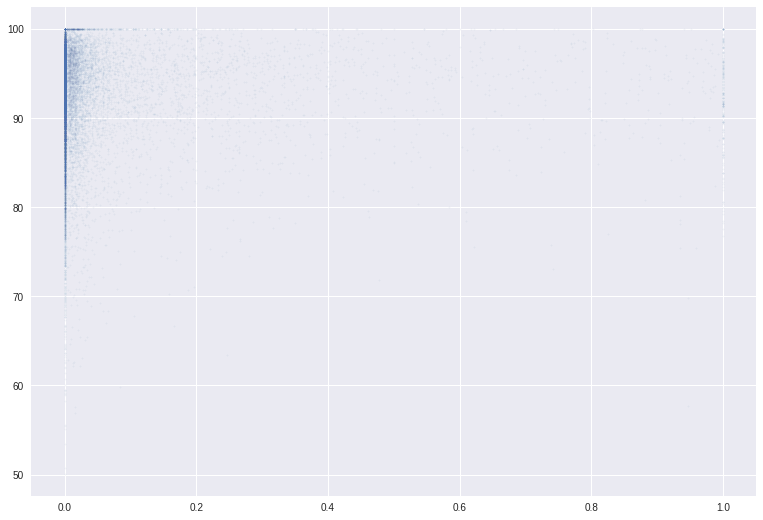

            Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: employment_rate
No. Observations:  15653   Method:             REML           
No. Groups:        5274    Scale:              8.5446         
Min. group size:   1       Likelihood:         -45256.3185    
Max. group size:   3       Converged:          Yes            
Mean group size:   3.0                                        
--------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept         92.102    0.077 1190.361 0.000 91.950 92.253
perc_tech50_avail  2.113    0.180   11.726 0.000  1.760  2.466
groups RE         28.064    0.255                             

prop_educ_college_educ


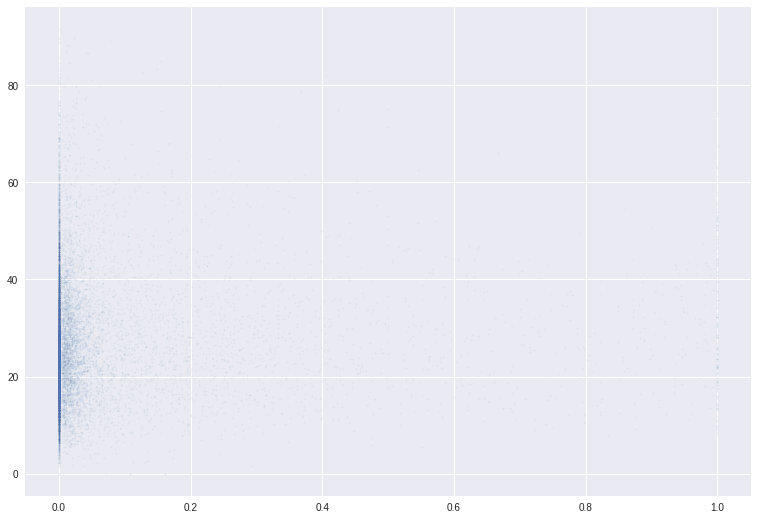

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: prop_educ_college_educ
No. Observations: 15653   Method:             REML                  
No. Groups:       5274    Scale:              11.7808               
Min. group size:  1       Likelihood:         -51126.7925           
Max. group size:  3       Converged:          Yes                   
Mean group size:  3.0                                               
---------------------------------------------------------------------
                     Coef.   Std.Err.     z     P>|z|  [0.025  0.975]
---------------------------------------------------------------------
Intercept            26.948     0.171  157.986  0.000  26.613  27.282
perc_tech50_avail     1.619     0.217    7.446  0.000   1.192   2.045
groups RE           148.552     1.063                                



In [7]:
df = pd.read_gbq(query_temp.format("<= 0.2", "IN"), project_id='fccdsicapstone-218522', dialect='standard')
df = preprocess(df)
for var in list_var:    
    print(var)
    viz(df, var, "perc_tech50_avail", var in list_log)
    model = mix_model(df, var, "perc_tech50_avail")
    print(model.summary())

### Urban, Not Obtain Fiber

median_home_value


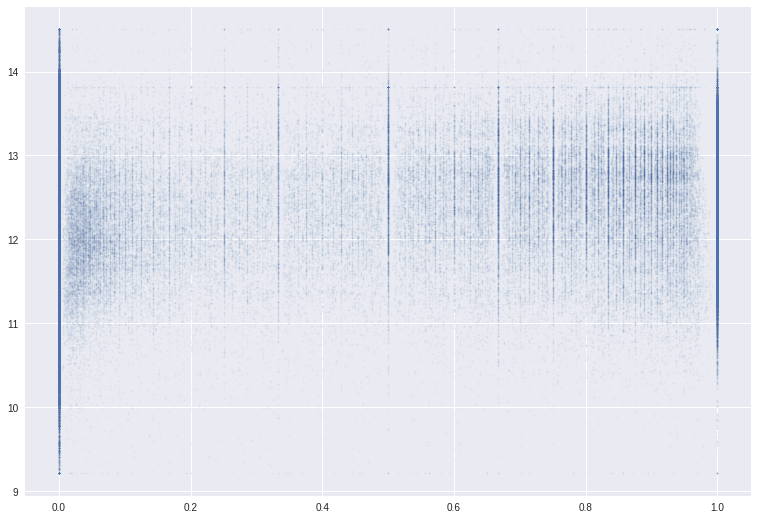

                    Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      median_home_value
No. Observations:      374847       Method:                  REML             
No. Groups:            127870       Scale:                   2418785272.2749  
Min. group size:       1            Likelihood:              -4839820.4102    
Max. group size:       3            Converged:               Yes              
Mean group size:       2.9                                                    
------------------------------------------------------------------------------
                       Coef.      Std.Err.    z    P>|z|   [0.025     0.975]  
------------------------------------------------------------------------------
Intercept              233710.420  657.241 355.593 0.000 232422.252 234998.588
perc_tech50_avail       62863.998 1071.577  58.665 0.000  60763.745  64964.251
groups RE         46568357655.329 4737.828                               

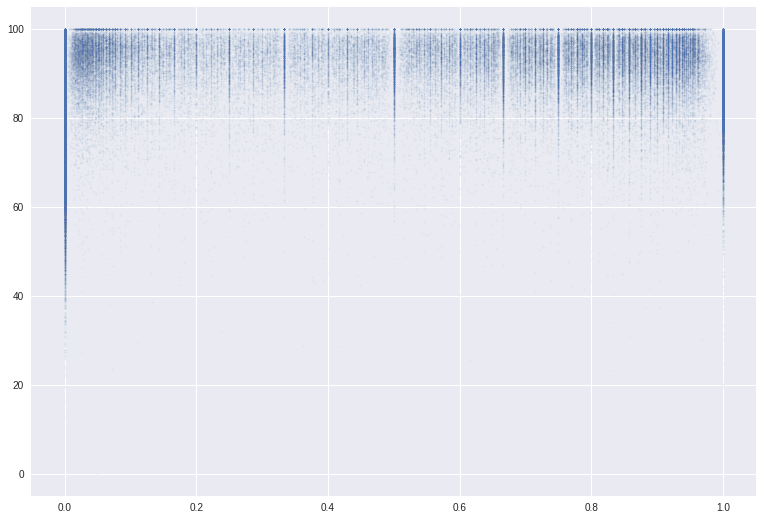

            Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: employment_rate
No. Observations:  374838  Method:             REML           
No. Groups:        127869  Scale:              12.3793        
Min. group size:   1       Likelihood:         -1165785.8394  
Max. group size:   3       Converged:          Yes            
Mean group size:   2.9                                        
--------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept         90.384    0.023 3858.396 0.000 90.338 90.430
perc_tech50_avail  1.439    0.049   29.589 0.000  1.344  1.535
groups RE         49.718    0.075                             

prop_educ_college_educ


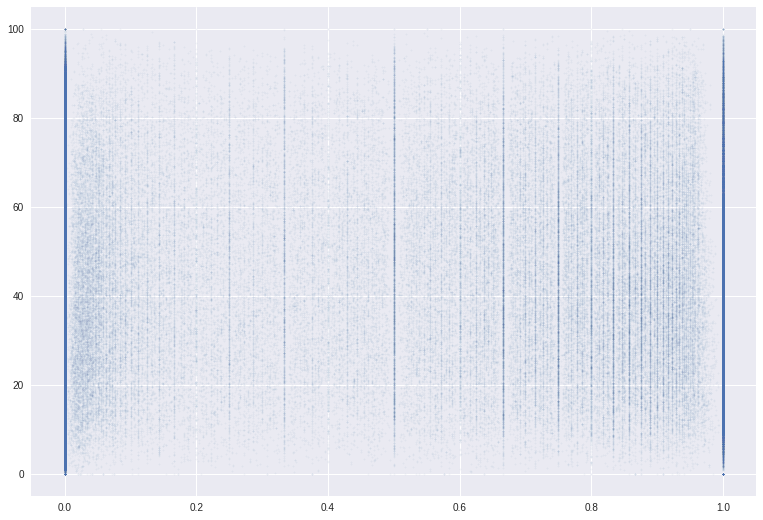

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: prop_educ_college_educ
No. Observations: 374847  Method:             REML                  
No. Groups:       127870  Scale:              17.6256               
Min. group size:  1       Likelihood:         -1342895.3103         
Max. group size:  3       Converged:          Yes                   
Mean group size:  2.9                                               
---------------------------------------------------------------------
                     Coef.   Std.Err.     z     P>|z|  [0.025  0.975]
---------------------------------------------------------------------
Intercept            37.294     0.062  597.868  0.000  37.172  37.417
perc_tech50_avail     3.665     0.095   38.486  0.000   3.478   3.851
groups RE           429.637     0.508                                



In [8]:
df = pd.read_gbq(query_temp.format(">= 0.8", "NOT IN"), project_id='fccdsicapstone-218522', dialect='standard')
df = preprocess(df)
for var in list_var:    
    print(var)
    viz(df, var, "perc_tech50_avail", var in list_log)
    model = mix_model(df, var, "perc_tech50_avail")
    print(model.summary())

### Rural, Not Obtain Fiber

median_home_value


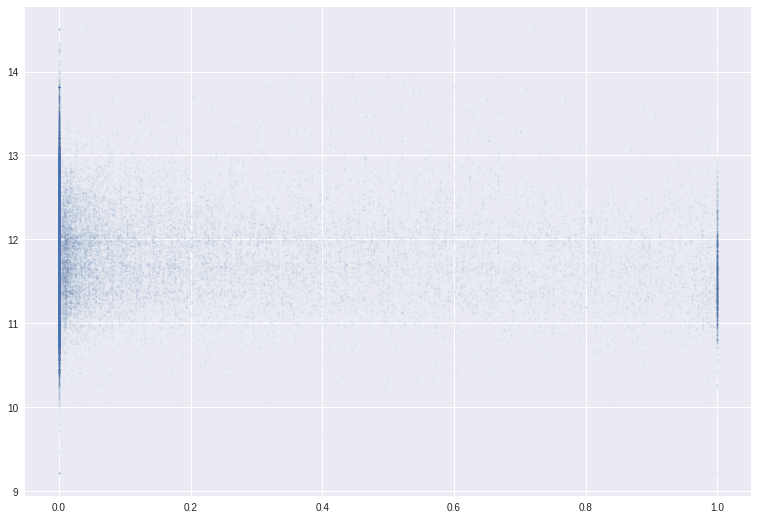

                    Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      median_home_value
No. Observations:      98259        Method:                  REML             
No. Groups:            33120        Scale:                   506586296.4627   
Min. group size:       1            Likelihood:              -1195507.1274    
Max. group size:       3            Converged:               Yes              
Mean group size:       3.0                                                    
------------------------------------------------------------------------------
                       Coef.      Std.Err.    z    P>|z|   [0.025     0.975]  
------------------------------------------------------------------------------
Intercept              154308.401  632.035 244.145 0.000 153069.635 155547.167
perc_tech50_avail         534.180 1303.000   0.410 0.682  -2019.654   3088.014
groups RE         12603461804.048 5419.501                               

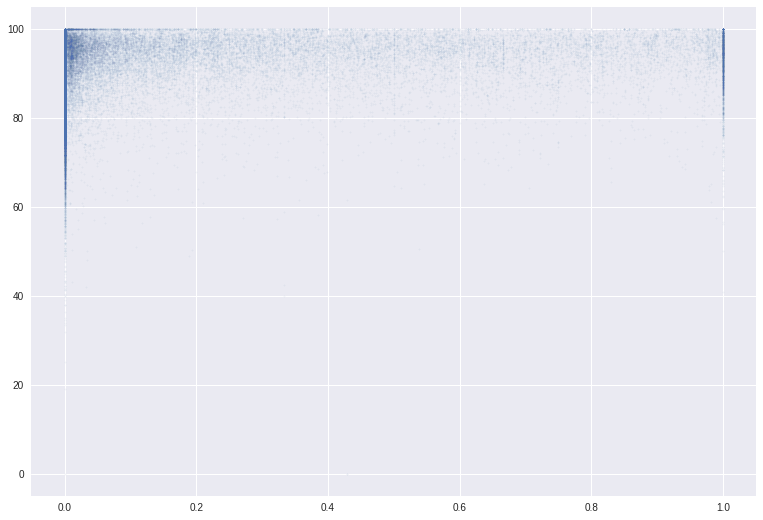

            Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: employment_rate
No. Observations:  98254   Method:             REML           
No. Groups:        33118   Scale:              9.4265         
Min. group size:   1       Likelihood:         -289427.5035   
Max. group size:   3       Converged:          Yes            
Mean group size:   3.0                                        
--------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept         92.022    0.034 2682.188 0.000 91.955 92.090
perc_tech50_avail  1.497    0.118   12.729 0.000  1.267  1.728
groups RE         32.067    0.111                             

prop_educ_college_educ


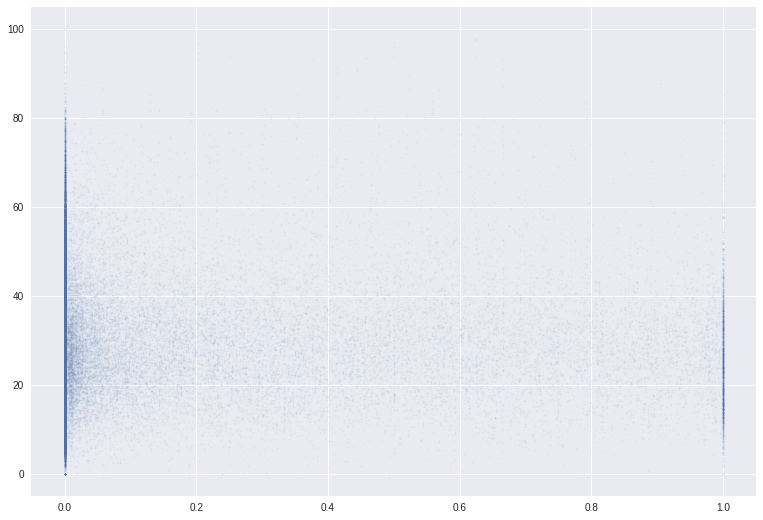

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: prop_educ_college_educ
No. Observations: 98259   Method:             REML                  
No. Groups:       33120   Scale:              12.2937               
Min. group size:  1       Likelihood:         -322866.6171          
Max. group size:  3       Converged:          Yes                   
Mean group size:  3.0                                               
---------------------------------------------------------------------
                     Coef.   Std.Err.     z     P>|z|  [0.025  0.975]
---------------------------------------------------------------------
Intercept            27.578     0.071  388.890  0.000  27.439  27.717
perc_tech50_avail     1.535     0.184    8.341  0.000   1.174   1.895
groups RE           153.310     0.429                                



In [9]:
df = pd.read_gbq(query_temp.format("<= 0.2", "NOT IN"), project_id='fccdsicapstone-218522', dialect='standard')
df = preprocess(df)
for var in list_var:    
    print(var)
    viz(df, var, "perc_tech50_avail", var in list_log)
    model = mix_model(df, var, "perc_tech50_avail")
    print(model.summary())

In [0]:
# High Speed Access Rate

In [0]:
query_temp = """
SELECT block_group_code, employment_rate, prop_educ_college_educ, median_home_value, population_density, perc_high_spd
FROM broadband.fcc_acs_with_geo_and_props_2014_table
WHERE median_home_value > 0 AND perc_urban {0} AND block_group_code {1} (SELECT block_group_code FROM broadband.blockgroup_gain_high_spd)

UNION ALL

SELECT block_group_code, employment_rate, prop_educ_college_educ, median_home_value, population_density, perc_high_spd
FROM broadband.fcc_acs_with_geo_and_props_2015_table
WHERE median_home_value > 0 AND perc_urban {0} AND block_group_code {1} (SELECT block_group_code FROM broadband.blockgroup_gain_high_spd)

UNION ALL

SELECT block_group_code, employment_rate, prop_educ_college_educ, median_home_value, population_density, perc_high_spd
FROM broadband.fcc_acs_with_geo_and_props_2016_table
WHERE median_home_value > 0 AND perc_urban {0} AND block_group_code {1} (SELECT block_group_code FROM broadband.blockgroup_gain_high_spd)
"""

median_home_value


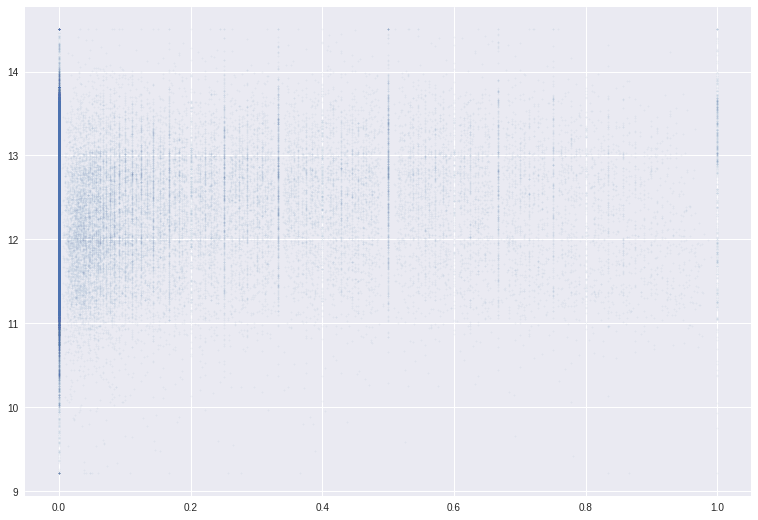

                   Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     median_home_value
No. Observations:     73948       Method:                 REML             
No. Groups:           25021       Scale:                  2093396175.6795  
Min. group size:      1           Likelihood:             -951735.4787     
Max. group size:      3           Converged:              Yes              
Mean group size:      3.0                                                  
---------------------------------------------------------------------------
                   Coef.       Std.Err.    z    P>|z|   [0.025     0.975]  
---------------------------------------------------------------------------
Intercept          298997.745  1423.190 210.090 0.000 296208.343 301787.147
perc_high_spd       27699.593   870.738  31.812 0.000  25992.979  29406.207
groups RE     49727614125.569 12124.058                                    

employment_rate


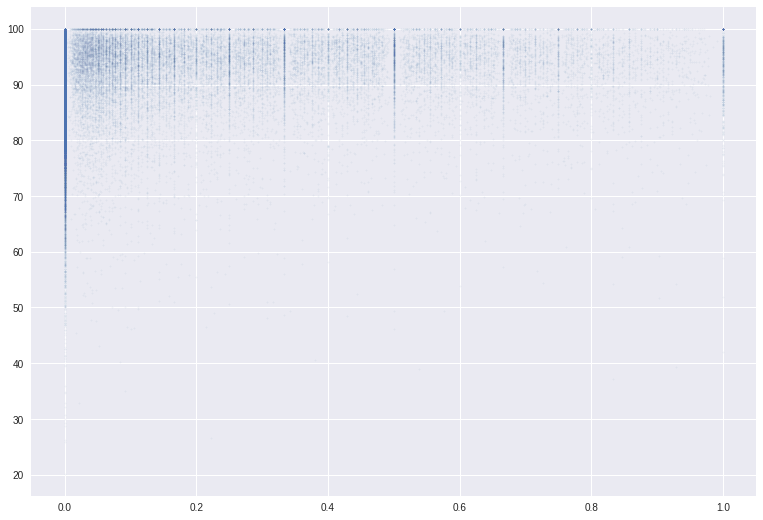

            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: employment_rate
No. Observations: 73948   Method:             REML           
No. Groups:       25021   Scale:              9.1495         
Min. group size:  1       Likelihood:         -219655.1681   
Max. group size:  3       Converged:          Yes            
Mean group size:  3.0                                        
-------------------------------------------------------------
                 Coef.  Std.Err.    z     P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept        91.549    0.042 2180.052 0.000 91.467 91.631
perc_high_spd     2.277    0.057   39.833 0.000  2.165  2.389
groups RE        39.985    0.158                             

prop_educ_college_educ


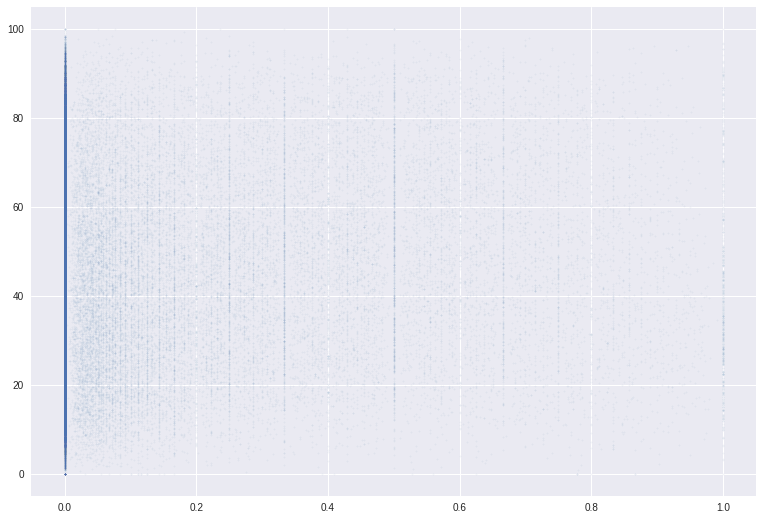

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: prop_educ_college_educ
No. Observations: 73948   Method:             REML                  
No. Groups:       25021   Scale:              17.3060               
Min. group size:  1       Likelihood:         -264692.4441          
Max. group size:  3       Converged:          Yes                   
Mean group size:  3.0                                               
----------------------------------------------------------------------
                 Coef.    Std.Err.      z      P>|z|   [0.025   0.975]
----------------------------------------------------------------------
Intercept        44.711      0.135   331.233   0.000   44.446   44.975
perc_high_spd     2.047      0.079    25.858   0.000    1.892    2.203
groups RE       448.026      1.200                                    



In [12]:
df = pd.read_gbq(query_temp.format(">= 0.8", "IN"), project_id='fccdsicapstone-218522', dialect='standard')
df = preprocess(df)
for var in list_var:    
    print(var)
    viz(df, var, "perc_high_spd", var in list_log)
    model = mix_model(df, var, "perc_high_spd")
    print(model.summary())

median_home_value


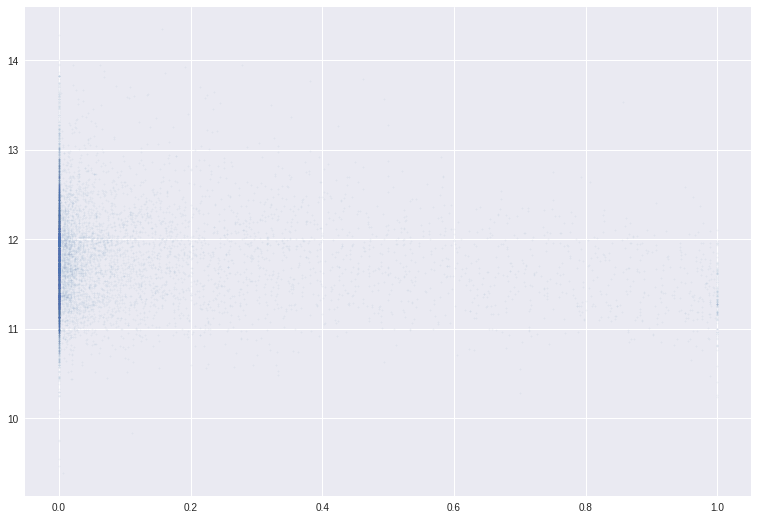

                  Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    median_home_value
No. Observations:      11617      Method:                REML             
No. Groups:            3905       Scale:                 295876855.6654   
Min. group size:       1          Likelihood:            -139003.7139     
Max. group size:       3          Converged:             Yes              
Mean group size:       3.0                                                
--------------------------------------------------------------------------
                   Coef.       Std.Err.   z    P>|z|   [0.025     0.975]  
--------------------------------------------------------------------------
Intercept          153333.192  1705.902 89.884 0.000 149989.685 156676.698
perc_high_spd        8376.314   991.606  8.447 0.000   6432.802  10319.826
groups RE     11227880033.776 18299.894                                   

employment_rate


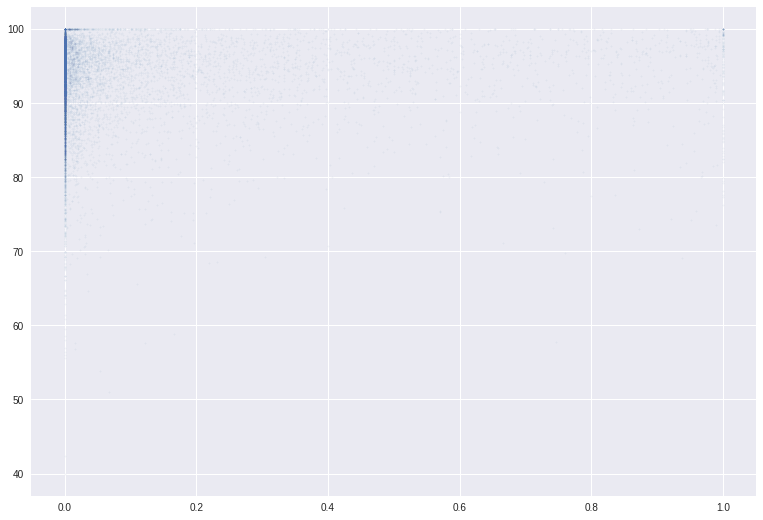

            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: employment_rate
No. Observations: 11615   Method:             REML           
No. Groups:       3904    Scale:              7.3717         
Min. group size:  1       Likelihood:         -32822.5221    
Max. group size:  3       Converged:          Yes            
Mean group size:  3.0                                        
-------------------------------------------------------------
                 Coef.  Std.Err.    z     P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept        92.925    0.086 1078.140 0.000 92.756 93.094
perc_high_spd     1.716    0.152   11.303 0.000  1.418  2.013
groups RE        25.667    0.289                             

prop_educ_college_educ


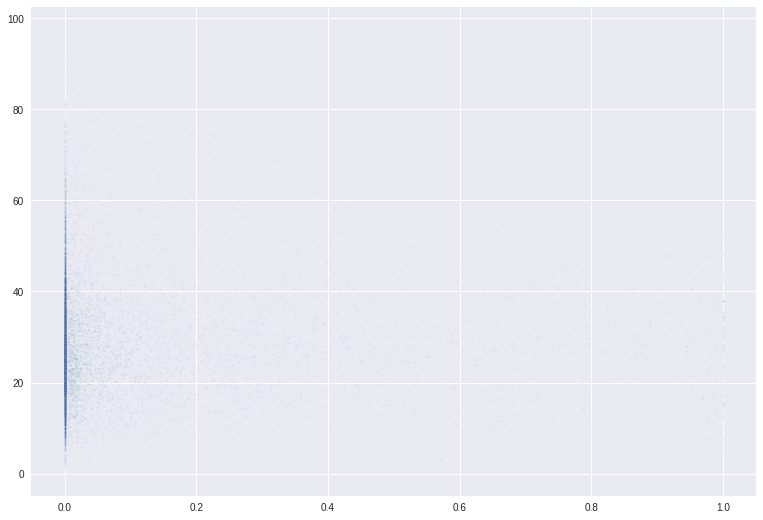

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: prop_educ_college_educ
No. Observations: 11617   Method:             REML                  
No. Groups:       3905    Scale:              11.5899               
Min. group size:  1       Likelihood:         -37990.5108           
Max. group size:  3       Converged:          Yes                   
Mean group size:  3.0                                               
----------------------------------------------------------------------
                 Coef.    Std.Err.      z      P>|z|   [0.025   0.975]
----------------------------------------------------------------------
Intercept        28.754      0.205   140.484   0.000   28.353   29.155
perc_high_spd     1.709      0.195     8.760   0.000    1.326    2.091
groups RE       158.278      1.324                                    



In [13]:
df = pd.read_gbq(query_temp.format("<= 0.2", "IN"), project_id='fccdsicapstone-218522', dialect='standard')
df = preprocess(df)
for var in list_var:    
    print(var)
    viz(df, var, "perc_high_spd", var in list_log)
    model = mix_model(df, var, "perc_high_spd")
    print(model.summary())

median_home_value


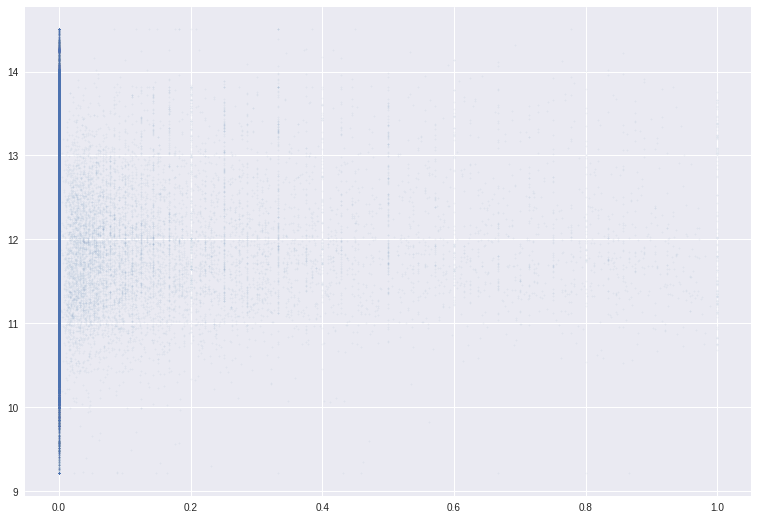

                  Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    median_home_value
No. Observations:      363048     Method:                REML             
No. Groups:            123989     Scale:                 2328638626.4722  
Min. group size:       1          Likelihood:            -4681869.8267    
Max. group size:       3          Converged:             Yes              
Mean group size:       2.9                                                
--------------------------------------------------------------------------
                   Coef.      Std.Err.    z    P>|z|   [0.025     0.975]  
--------------------------------------------------------------------------
Intercept          234874.020  612.467 383.488 0.000 233673.607 236074.434
perc_high_spd        7807.744 2959.556   2.638 0.008   2007.122  13608.367
groups RE     45648623604.231 4765.991                                    

employment_rate


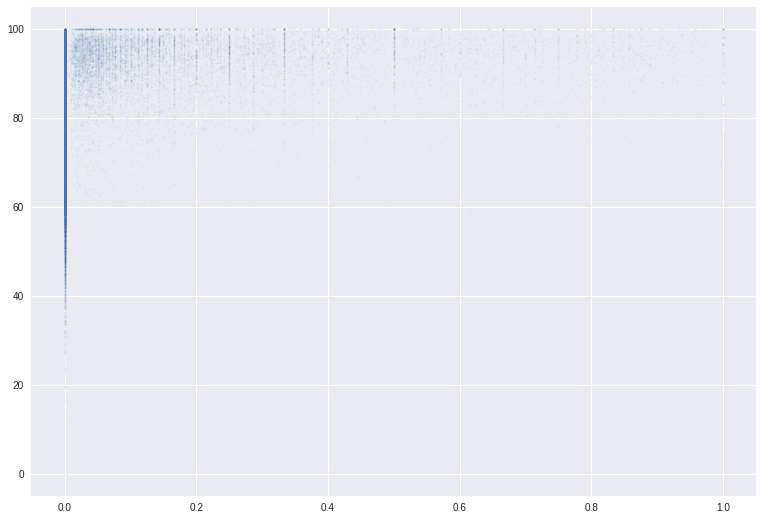

            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: employment_rate
No. Observations: 363037  Method:             REML           
No. Groups:       123987  Scale:              12.7578        
Min. group size:  1       Likelihood:         -1133692.7696  
Max. group size:  3       Converged:          Yes            
Mean group size:  2.9                                        
-------------------------------------------------------------
                 Coef.  Std.Err.    z     P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept        90.624    0.021 4300.533 0.000 90.583 90.665
perc_high_spd     0.820    0.200    4.092 0.000  0.427  1.213
groups RE        50.394    0.077                             

prop_educ_college_educ


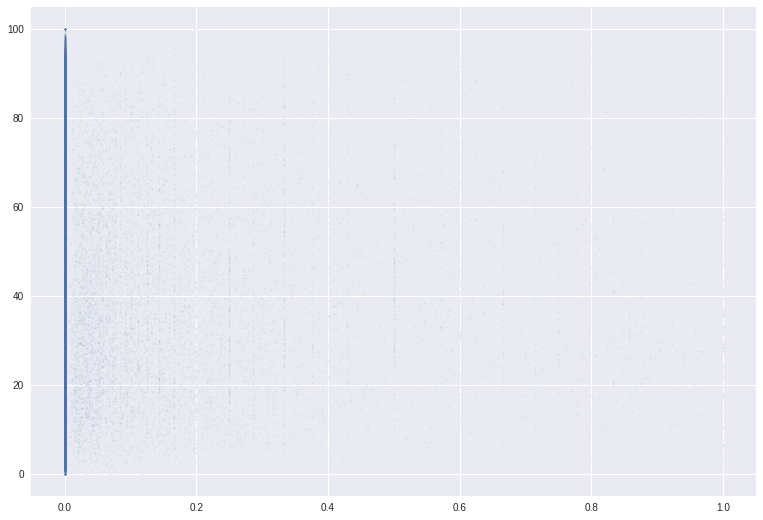

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: prop_educ_college_educ
No. Observations: 363048  Method:             REML                  
No. Groups:       123989  Scale:              17.5786               
Min. group size:  1       Likelihood:         -1300420.2349         
Max. group size:  3       Converged:          Yes                   
Mean group size:  2.9                                               
----------------------------------------------------------------------
                 Coef.    Std.Err.      z      P>|z|   [0.025   0.975]
----------------------------------------------------------------------
Intercept        37.265      0.059   628.766   0.000   37.149   37.381
perc_high_spd     0.740      0.258     2.862   0.004    0.233    1.246
groups RE       429.017      0.514                                    



In [14]:
df = pd.read_gbq(query_temp.format(">= 0.8", "NOT IN"), project_id='fccdsicapstone-218522', dialect='standard')
df = preprocess(df)
for var in list_var:    
    print(var)
    viz(df, var, "perc_high_spd", var in list_log)
    model = mix_model(df, var, "perc_high_spd")
    print(model.summary())

median_home_value


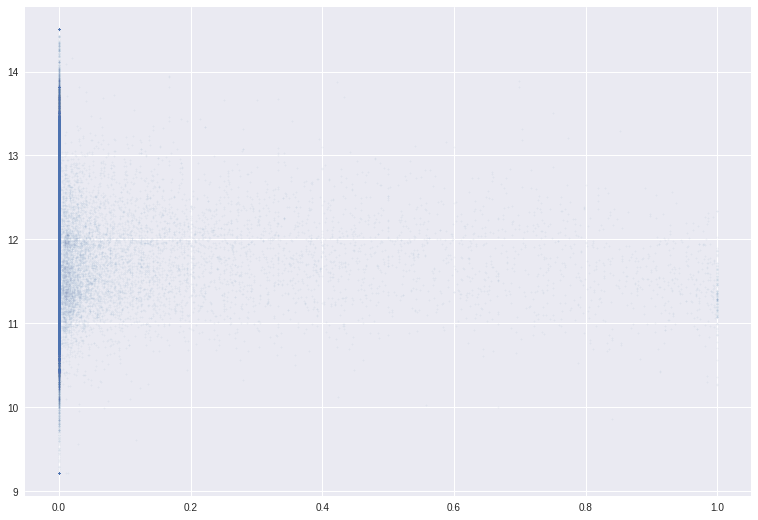

                  Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    median_home_value
No. Observations:      158388     Method:                REML             
No. Groups:            53463      Scale:                 681560157.0414   
Min. group size:       1          Likelihood:            -1950669.9348    
Max. group size:       3          Converged:             Yes              
Mean group size:       3.0                                                
--------------------------------------------------------------------------
                   Coef.      Std.Err.    z    P>|z|   [0.025     0.975]  
--------------------------------------------------------------------------
Intercept          167076.754  567.201 294.564 0.000 165965.060 168188.447
perc_high_spd        1275.540 2403.769   0.531 0.596  -3435.761   5986.841
groups RE     16934569642.970 4942.925                                    

employment_rate


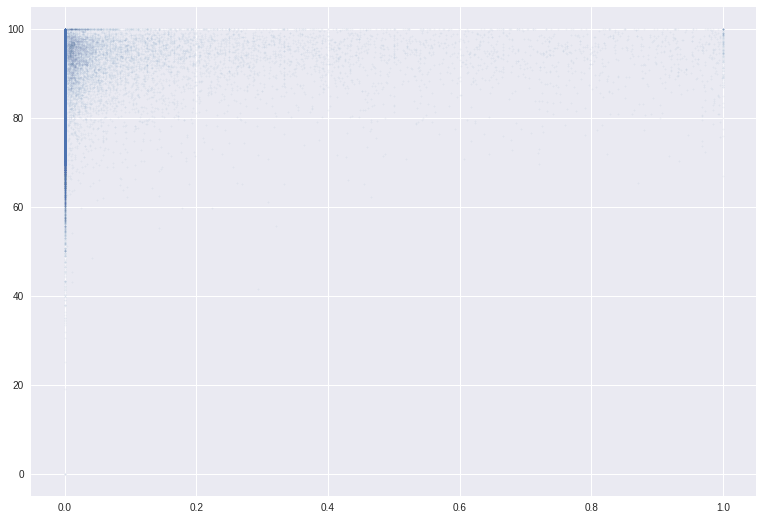

            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: employment_rate
No. Observations: 158384  Method:             REML           
No. Groups:       53462   Scale:              9.7139         
Min. group size:  1       Likelihood:         -468574.3062   
Max. group size:  3       Converged:          Yes            
Mean group size:  3.0                                        
-------------------------------------------------------------
                 Coef.  Std.Err.    z     P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept        92.071    0.026 3541.739 0.000 92.020 92.122
perc_high_spd     1.083    0.234    4.629 0.000  0.625  1.542
groups RE        32.508    0.087                             

prop_educ_college_educ


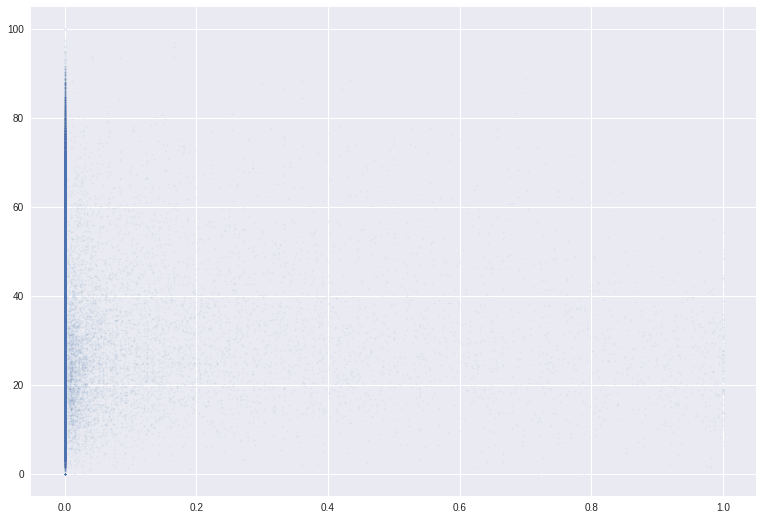

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: prop_educ_college_educ
No. Observations: 158388  Method:             REML                  
No. Groups:       53463   Scale:              13.0842               
Min. group size:  1       Likelihood:         -532243.0330          
Max. group size:  3       Converged:          Yes                   
Mean group size:  3.0                                               
----------------------------------------------------------------------
                 Coef.    Std.Err.      z      P>|z|   [0.025   0.975]
----------------------------------------------------------------------
Intercept        29.950      0.064   470.484   0.000   29.826   30.075
perc_high_spd     0.658      0.326     2.021   0.043    0.020    1.297
groups RE       211.588      0.449                                    



In [15]:
df = pd.read_gbq(query_temp.format("<= 0.8", "NOT IN"), project_id='fccdsicapstone-218522', dialect='standard')
df = preprocess(df)
for var in list_var:    
    print(var)
    viz(df, var, "perc_high_spd", var in list_log)
    model = mix_model(df, var, "perc_high_spd")
    print(model.summary())

# Fiber or Cable 3.1 (As binary variable)

In [0]:
query_temp = """
SELECT block_group_code, employment_rate, prop_educ_college_educ, median_home_value, population_density, perc_tech43_avail, perc_tech50_avail
FROM broadband.fcc_acs_with_geo_and_props_2014_table
WHERE median_home_value > 0 AND perc_urban {0} AND block_group_code {1} (SELECT block_group_code FROM broadband.blockgroup_obtain_fiber_or_cable)

UNION ALL

SELECT block_group_code, employment_rate, prop_educ_college_educ, median_home_value, population_density, perc_tech43_avail, perc_tech50_avail
FROM broadband.fcc_acs_with_geo_and_props_2015_table
WHERE median_home_value > 0 AND perc_urban {0} AND block_group_code {1} (SELECT block_group_code FROM broadband.blockgroup_obtain_fiber_or_cable)

UNION ALL

SELECT block_group_code, employment_rate, prop_educ_college_educ, median_home_value, population_density, perc_tech43_avail, perc_tech50_avail
FROM broadband.fcc_acs_with_geo_and_props_2016_table
WHERE median_home_value > 0 AND perc_urban {0} AND block_group_code {1} (SELECT block_group_code FROM broadband.blockgroup_obtain_fiber_or_cable)
"""

def add_binary(df, threshold):
    df["gain_fiber_cable"] = np.where((df["perc_tech43_avail"] <= threshold) & (df["perc_tech50_avail"] <= threshold), 0, 1)
    return df

median_home_value


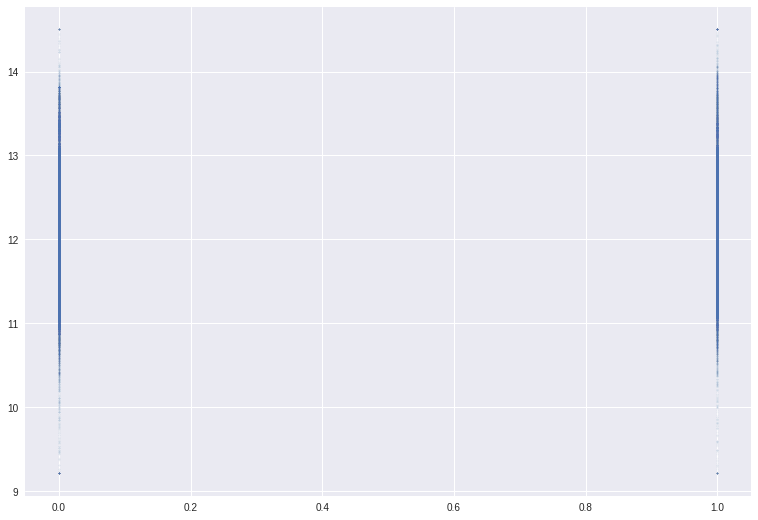

                    Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      median_home_value
No. Observations:      62335        Method:                  REML             
No. Groups:            21203        Scale:                   1554306482.9353  
Min. group size:       1            Likelihood:              -793724.2553     
Max. group size:       3            Converged:               Yes              
Mean group size:       2.9                                                    
------------------------------------------------------------------------------
                      Coef.       Std.Err.    z    P>|z|   [0.025     0.975]  
------------------------------------------------------------------------------
Intercept             227825.231  1373.732 165.844 0.000 225132.765 230517.697
gain_fiber_cable       14638.102   336.448  43.508 0.000  13978.676  15297.527
groups RE        39015888979.333 11998.143                               

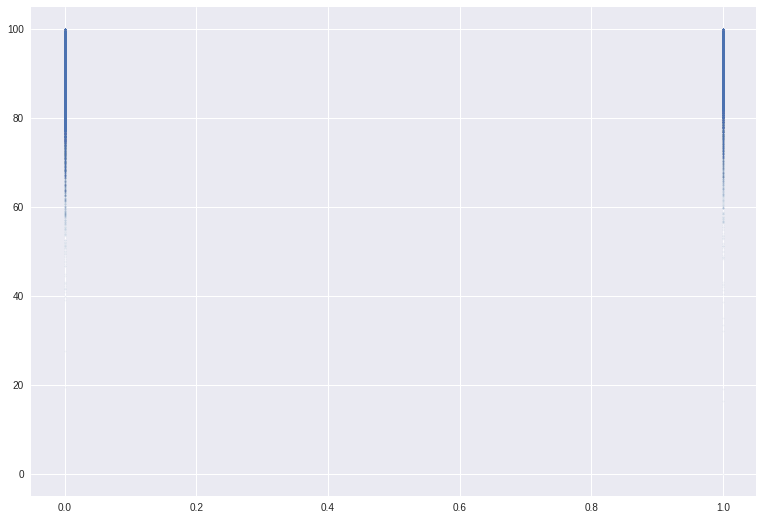

            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: employment_rate
No. Observations: 62333   Method:             REML           
No. Groups:       21202   Scale:              10.2938        
Min. group size:  1       Likelihood:         -188050.4023   
Max. group size:  3       Converged:          Yes            
Mean group size:  2.9                                        
-------------------------------------------------------------
                 Coef.  Std.Err.    z     P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept        90.830    0.047 1912.663 0.000 90.737 90.924
gain_fiber_cable  1.495    0.027   54.843 0.000  1.442  1.549
groups RE        41.241    0.168                             

prop_educ_college_educ


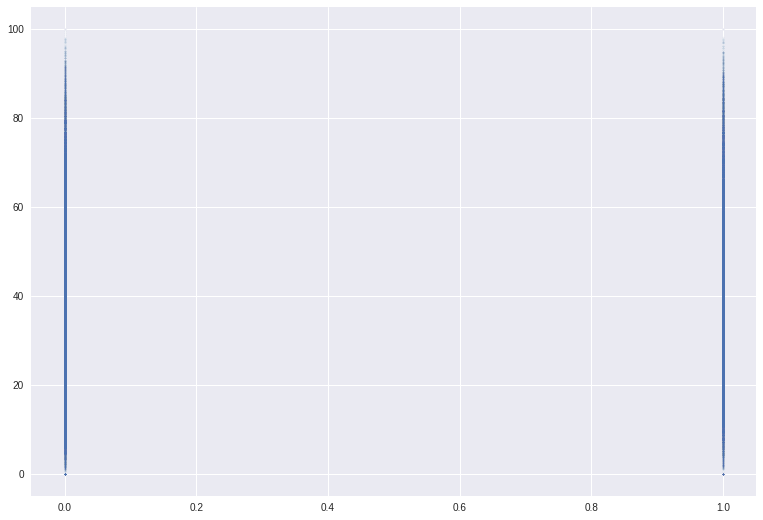

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: prop_educ_college_educ
No. Observations: 62335   Method:             REML                  
No. Groups:       21203   Scale:              17.1000               
Min. group size:  1       Likelihood:         -223280.1807          
Max. group size:  3       Converged:          Yes                   
Mean group size:  2.9                                               
---------------------------------------------------------------------
                     Coef.   Std.Err.     z     P>|z|  [0.025  0.975]
---------------------------------------------------------------------
Intercept            40.673     0.149  273.349  0.000  40.381  40.964
gain_fiber_cable      1.000     0.035   28.330  0.000   0.931   1.069
groups RE           458.459     1.343                                



In [32]:
df = pd.read_gbq(query_temp.format(">= 0.8", "IN"), project_id='fccdsicapstone-218522', dialect='standard')
df = preprocess(df)
df = add_binary(df, 0)
for var in list_var:    
    print(var)
    viz(df, var, "gain_fiber_cable", var in list_log)
    model = mix_model(df, var, "gain_fiber_cable")
    print(model.summary())

median_home_value


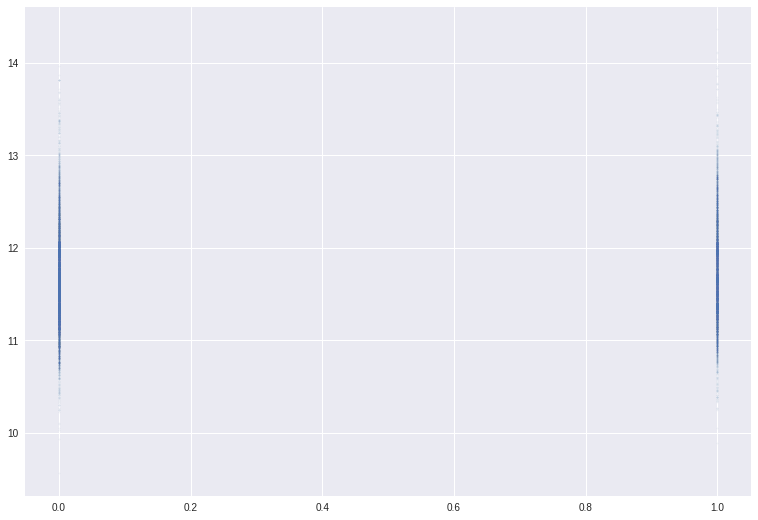

                    Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     median_home_value
No. Observations:       15656       Method:                 REML             
No. Groups:             5275        Scale:                  303718249.6641   
Min. group size:        1           Likelihood:             -186884.6335     
Max. group size:        3           Converged:              Yes              
Mean group size:        3.0                                                  
-----------------------------------------------------------------------------
                     Coef.       Std.Err.    z    P>|z|   [0.025     0.975]  
-----------------------------------------------------------------------------
Intercept            139746.086  1311.383 106.564 0.000 137175.822 142316.350
gain_fiber_cable       4370.460   295.984  14.766 0.000   3790.341   4950.578
groups RE        8879796019.825 12329.691                                    

emplo

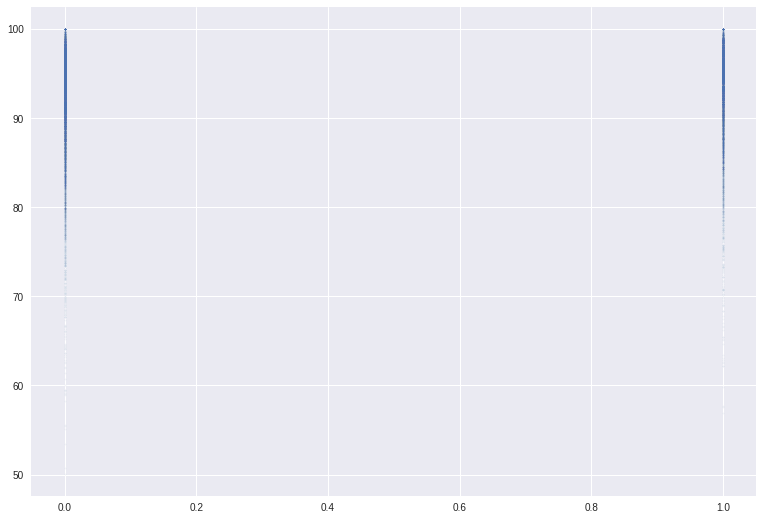

            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: employment_rate
No. Observations: 15656   Method:             REML           
No. Groups:       5275    Scale:              8.1883         
Min. group size:  1       Likelihood:         -45038.9341    
Max. group size:  3       Converged:          Yes            
Mean group size:  3.0                                        
-------------------------------------------------------------
                 Coef.  Std.Err.    z     P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept        91.706    0.079 1154.933 0.000 91.551 91.862
gain_fiber_cable  1.191    0.048   24.622 0.000  1.096  1.286
groups RE        28.111    0.260                             

prop_educ_college_educ


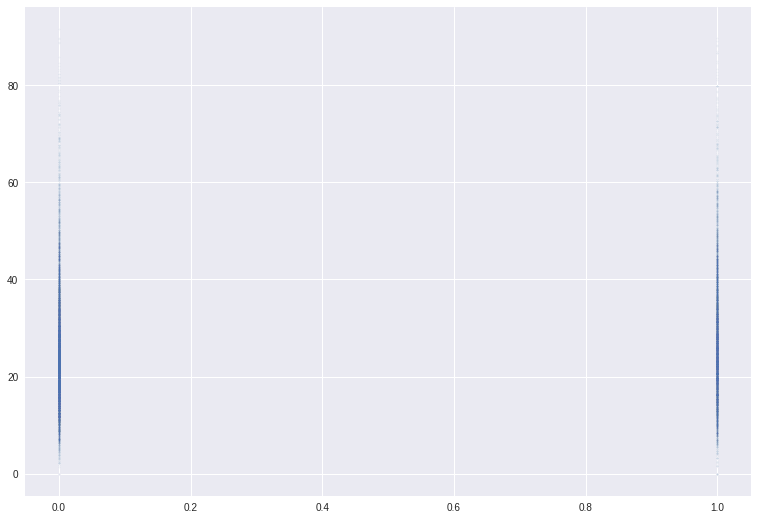

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: prop_educ_college_educ
No. Observations: 15656   Method:             REML                  
No. Groups:       5275    Scale:              11.5820               
Min. group size:  1       Likelihood:         -51048.2686           
Max. group size:  3       Converged:          Yes                   
Mean group size:  3.0                                               
---------------------------------------------------------------------
                     Coef.   Std.Err.     z     P>|z|  [0.025  0.975]
---------------------------------------------------------------------
Intercept            26.658     0.172  155.088  0.000  26.321  26.995
gain_fiber_cable      0.885     0.058   15.319  0.000   0.772   0.998
groups RE           148.546     1.072                                



In [33]:
df = pd.read_gbq(query_temp.format("<= 0.2", "IN"), project_id='fccdsicapstone-218522', dialect='standard')
df = preprocess(df)
df = add_binary(df, 0)
for var in list_var:    
    print(var)
    viz(df, var, "gain_fiber_cable", var in list_log)
    model = mix_model(df, var, "gain_fiber_cable")
    print(model.summary())

median_home_value


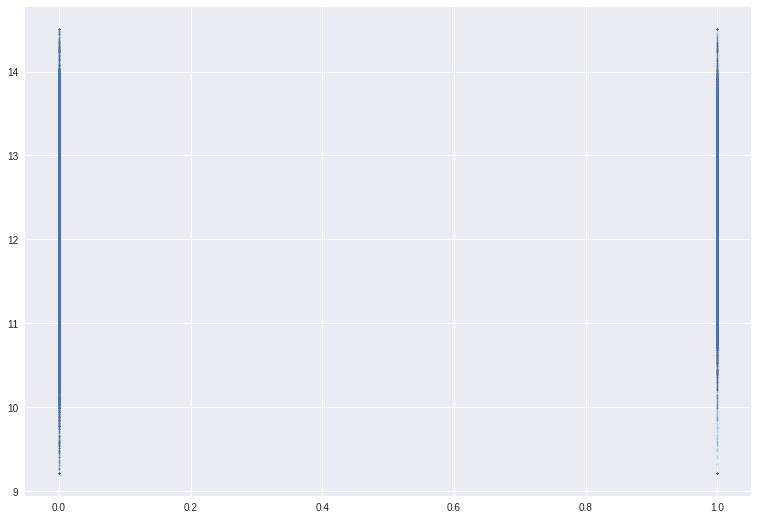

                    Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     median_home_value
No. Observations:       374661      Method:                 REML             
No. Groups:             127807      Scale:                  2420715633.6038  
Min. group size:        1           Likelihood:             -4838245.2356    
Max. group size:        3           Converged:              Yes              
Mean group size:        2.9                                                  
-----------------------------------------------------------------------------
                      Coef.      Std.Err.    z    P>|z|   [0.025     0.975]  
-----------------------------------------------------------------------------
Intercept             236652.829  673.574 351.339 0.000 235332.648 237973.009
gain_fiber_cable       33107.770  803.943  41.182 0.000  31532.071  34683.469
groups RE        47110181998.367 4800.844                                    

emplo

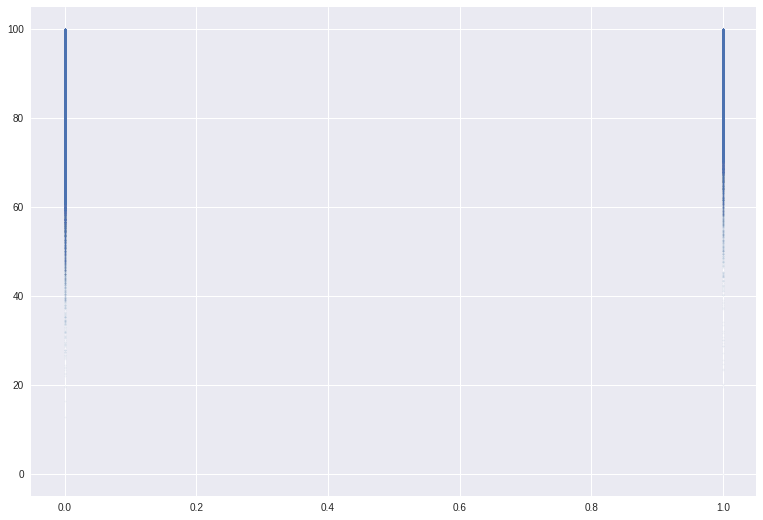

            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: employment_rate
No. Observations: 374652  Method:             REML           
No. Groups:       127806  Scale:              12.4107        
Min. group size:  1       Likelihood:         -1165271.6185  
Max. group size:  3       Converged:          Yes            
Mean group size:  2.9                                        
-------------------------------------------------------------
                 Coef.  Std.Err.    z     P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept        90.345    0.024 3716.205 0.000 90.298 90.393
gain_fiber_cable  1.066    0.037   28.497 0.000  0.993  1.139
groups RE        49.497    0.075                             

prop_educ_college_educ


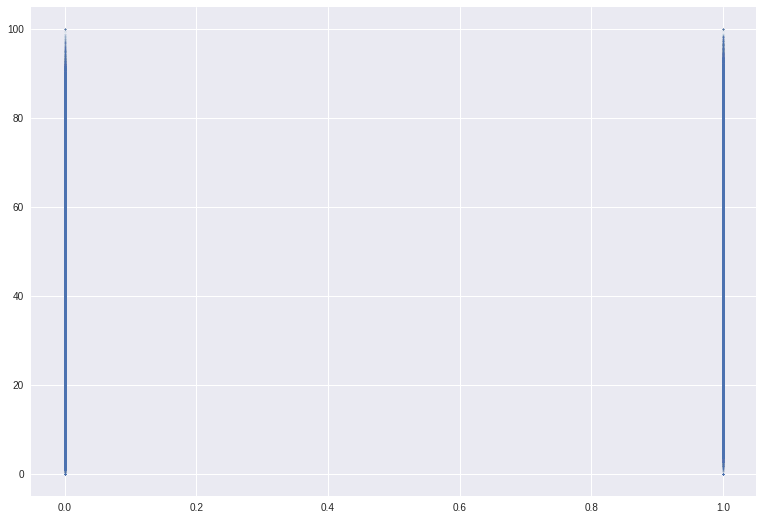

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: prop_educ_college_educ
No. Observations: 374661  Method:             REML                  
No. Groups:       127807  Scale:              17.6699               
Min. group size:  1       Likelihood:         -1342342.4136         
Max. group size:  3       Converged:          Yes                   
Mean group size:  2.9                                               
---------------------------------------------------------------------
                     Coef.   Std.Err.     z     P>|z|  [0.025  0.975]
---------------------------------------------------------------------
Intercept            37.252     0.063  587.939  0.000  37.128  37.376
gain_fiber_cable      2.533     0.071   35.576  0.000   2.393   2.672
groups RE           428.279     0.508                                



In [34]:
df = pd.read_gbq(query_temp.format(">= 0.8", "NOT IN"), project_id='fccdsicapstone-218522', dialect='standard')
df = preprocess(df)
df = add_binary(df, 0)
for var in list_var:    
    print(var)
    viz(df, var, "gain_fiber_cable", var in list_log)
    model = mix_model(df, var, "gain_fiber_cable")
    print(model.summary())

median_home_value


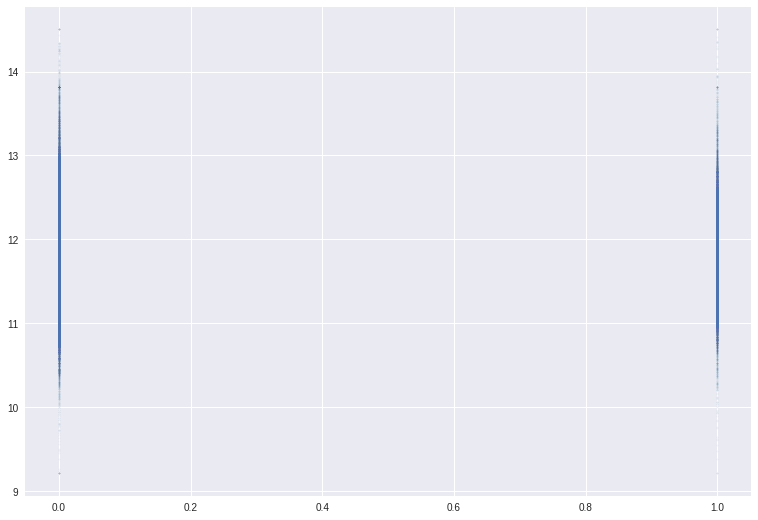

                    Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     median_home_value
No. Observations:       98256       Method:                 REML             
No. Groups:             33119       Scale:                  506523791.4038   
Min. group size:        1           Likelihood:             -1195467.6394    
Max. group size:        3           Converged:              Yes              
Mean group size:        3.0                                                  
-----------------------------------------------------------------------------
                      Coef.      Std.Err.    z    P>|z|   [0.025     0.975]  
-----------------------------------------------------------------------------
Intercept             154935.512  646.979 239.475 0.000 153667.457 156203.567
gain_fiber_cable       -2222.865  697.159  -3.188 0.001  -3589.272   -856.459
groups RE        12603784150.650 5418.859                                    

emplo

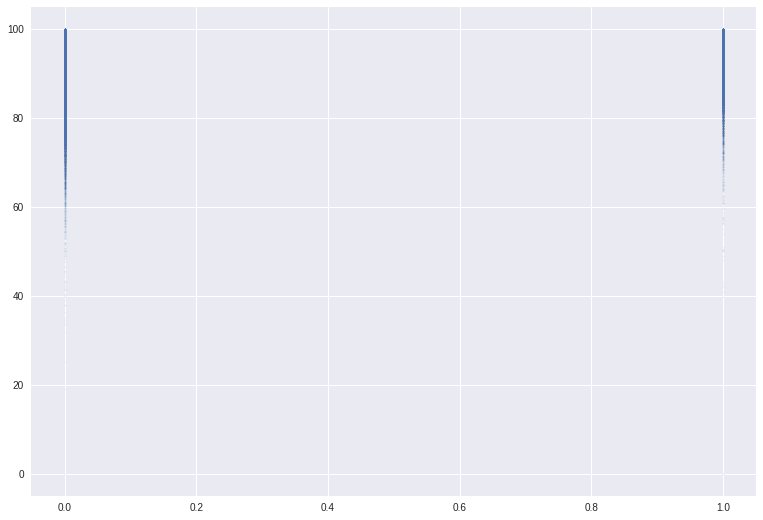

            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: employment_rate
No. Observations: 98251   Method:             REML           
No. Groups:       33117   Scale:              9.4484         
Min. group size:  1       Likelihood:         -289408.8816   
Max. group size:  3       Converged:          Yes            
Mean group size:  3.0                                        
-------------------------------------------------------------
                 Coef.  Std.Err.    z     P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept        91.936    0.036 2528.043 0.000 91.865 92.008
gain_fiber_cable  0.850    0.062   13.618 0.000  0.727  0.972
groups RE        31.877    0.110                             

prop_educ_college_educ


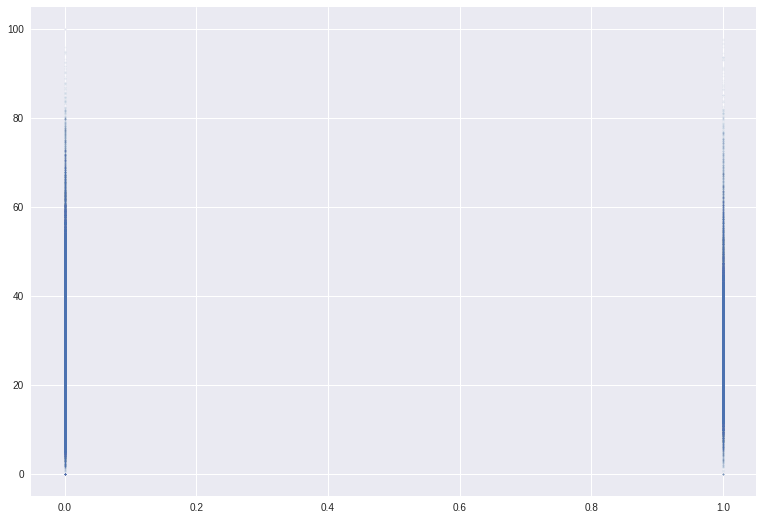

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: prop_educ_college_educ
No. Observations: 98256   Method:             REML                  
No. Groups:       33119   Scale:              12.3104               
Min. group size:  1       Likelihood:         -322861.3850          
Max. group size:  3       Converged:          Yes                   
Mean group size:  3.0                                               
---------------------------------------------------------------------
                     Coef.   Std.Err.     z     P>|z|  [0.025  0.975]
---------------------------------------------------------------------
Intercept            27.512     0.073  374.509  0.000  27.368  27.656
gain_fiber_cable      0.786     0.098    7.998  0.000   0.594   0.979
groups RE           152.923     0.428                                



In [35]:
df = pd.read_gbq(query_temp.format("<= 0.2", "NOT IN"), project_id='fccdsicapstone-218522', dialect='standard')
df = preprocess(df)
df = add_binary(df, 0)
for var in list_var:    
    print(var)
    viz(df, var, "gain_fiber_cable", var in list_log)
    model = mix_model(df, var, "gain_fiber_cable")
    print(model.summary())

median_home_value


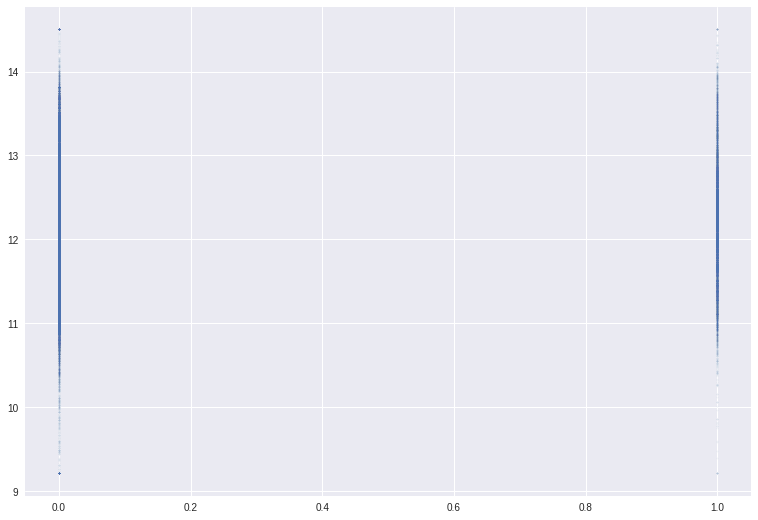

                    Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      median_home_value
No. Observations:      62335        Method:                  REML             
No. Groups:            21203        Scale:                   1588595932.7024  
Min. group size:       1            Likelihood:              -794150.6669     
Max. group size:       3            Converged:               Yes              
Mean group size:       2.9                                                    
------------------------------------------------------------------------------
                      Coef.       Std.Err.    z    P>|z|   [0.025     0.975]  
------------------------------------------------------------------------------
Intercept             231245.733  1367.651 169.082 0.000 228565.185 233926.280
gain_fiber_cable       16118.958   507.625  31.754 0.000  15124.032  17113.885
groups RE        38922115089.817 11843.890                               

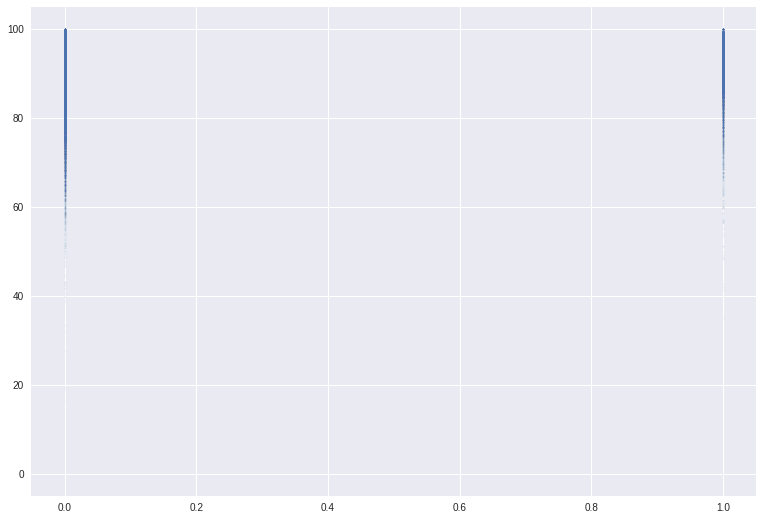

            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: employment_rate
No. Observations: 62333   Method:             REML           
No. Groups:       21202   Scale:              10.7144        
Min. group size:  1       Likelihood:         -188929.3582   
Max. group size:  3       Converged:          Yes            
Mean group size:  2.9                                        
-------------------------------------------------------------
                 Coef.  Std.Err.    z     P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept        91.226    0.047 1953.156 0.000 91.135 91.318
gain_fiber_cable  1.398    0.041   34.119 0.000  1.318  1.478
groups RE        41.331    0.166                             

prop_educ_college_educ


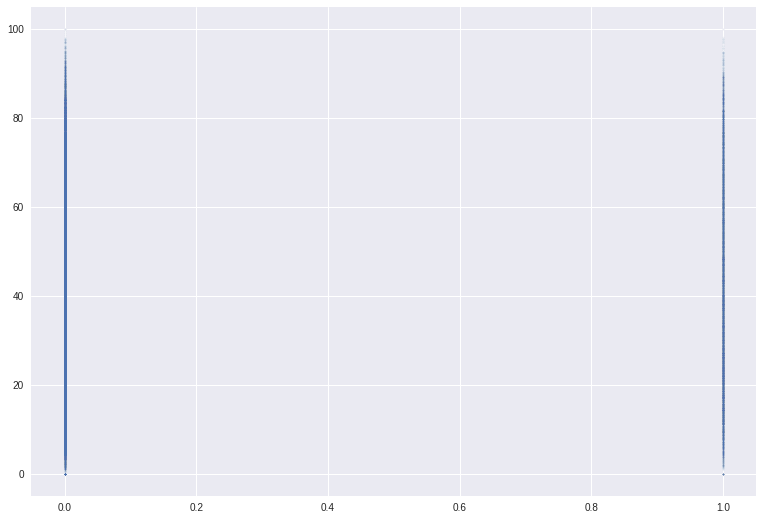

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: prop_educ_college_educ
No. Observations: 62335   Method:             REML                  
No. Groups:       21203   Scale:              17.2776               
Min. group size:  1       Likelihood:         -223489.4923          
Max. group size:  3       Converged:          Yes                   
Mean group size:  2.9                                               
---------------------------------------------------------------------
                     Coef.   Std.Err.     z     P>|z|  [0.025  0.975]
---------------------------------------------------------------------
Intercept            40.920     0.148  275.931  0.000  40.629  41.210
gain_fiber_cable      1.029     0.053   19.424  0.000   0.925   1.132
groups RE           458.274     1.336                                

median_home_value


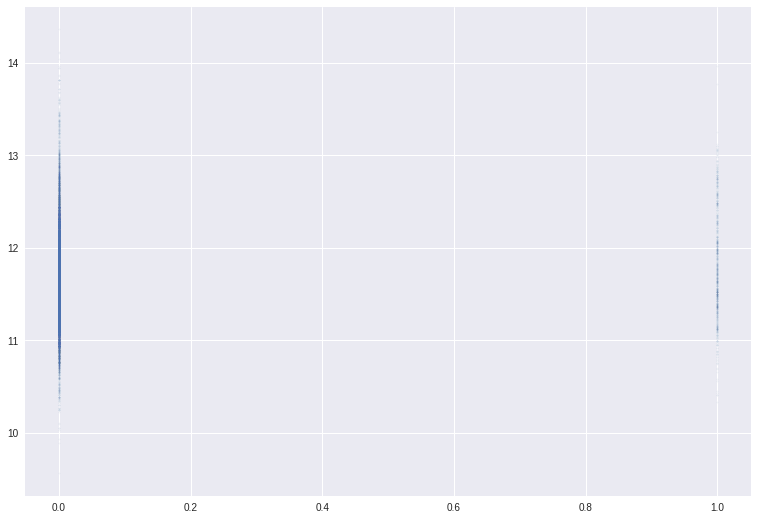

                    Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     median_home_value
No. Observations:       15656       Method:                 REML             
No. Groups:             5275        Scale:                  309549650.9648   
Min. group size:        1           Likelihood:             -186984.3264     
Max. group size:        3           Converged:              Yes              
Mean group size:        3.0                                                  
-----------------------------------------------------------------------------
                     Coef.       Std.Err.    z    P>|z|   [0.025     0.975]  
-----------------------------------------------------------------------------
Intercept            141476.331  1306.338 108.300 0.000 138915.955 144036.707
gain_fiber_cable       3144.492   824.915   3.812 0.000   1527.688   4761.297
groups RE        8884641633.408 12223.134                                    

emplo

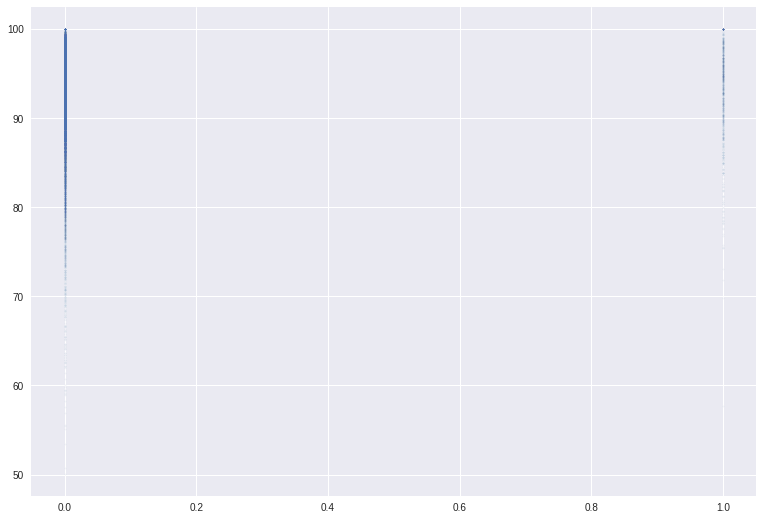

            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: employment_rate
No. Observations: 15656   Method:             REML           
No. Groups:       5275    Scale:              8.6051         
Min. group size:  1       Likelihood:         -45297.4054    
Max. group size:  3       Converged:          Yes            
Mean group size:  3.0                                        
-------------------------------------------------------------
                 Coef.  Std.Err.    z     P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept        92.163    0.077 1197.927 0.000 92.013 92.314
gain_fiber_cable  1.116    0.133    8.403 0.000  0.856  1.376
groups RE        27.991    0.254                             

prop_educ_college_educ


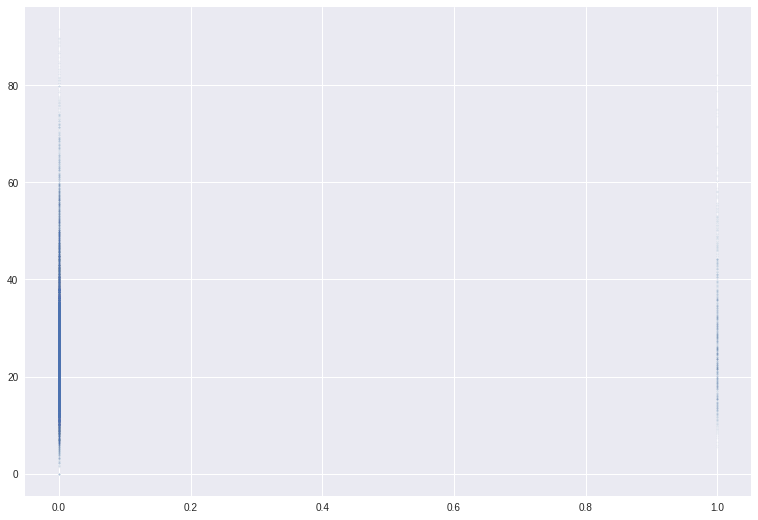

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: prop_educ_college_educ
No. Observations: 15656   Method:             REML                  
No. Groups:       5275    Scale:              11.8006               
Min. group size:  1       Likelihood:         -51147.0630           
Max. group size:  3       Converged:          Yes                   
Mean group size:  3.0                                               
---------------------------------------------------------------------
                     Coef.   Std.Err.     z     P>|z|  [0.025  0.975]
---------------------------------------------------------------------
Intercept            26.992     0.170  158.442  0.000  26.658  27.326
gain_fiber_cable      0.916     0.160    5.723  0.000   0.602   1.230
groups RE           148.631     1.063                                

median_home_value


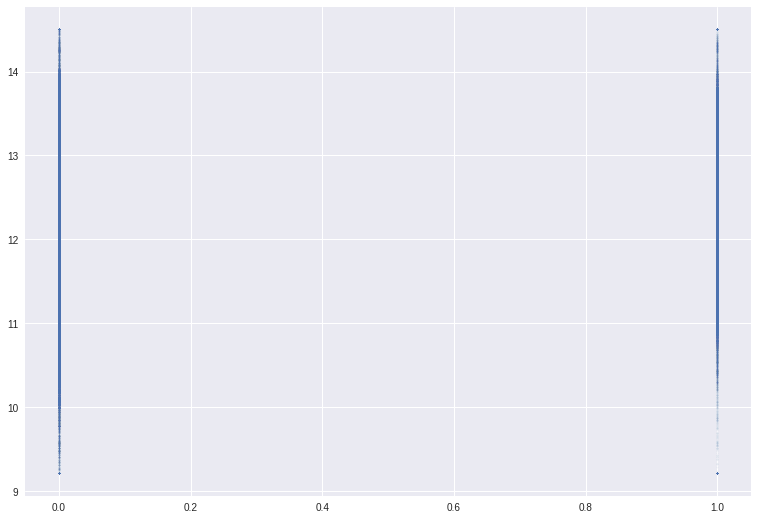

                    Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     median_home_value
No. Observations:       374661      Method:                 REML             
No. Groups:             127807      Scale:                  2419452510.1026  
Min. group size:        1           Likelihood:             -4837803.7750    
Max. group size:        3           Converged:              Yes              
Mean group size:        2.9                                                  
-----------------------------------------------------------------------------
                      Coef.      Std.Err.    z    P>|z|   [0.025     0.975]  
-----------------------------------------------------------------------------
Intercept             237163.115  648.196 365.882 0.000 235892.674 238433.557
gain_fiber_cable       39902.850  785.690  50.787 0.000  38362.925  41442.775
groups RE        46828476821.047 4774.574                                    

emplo

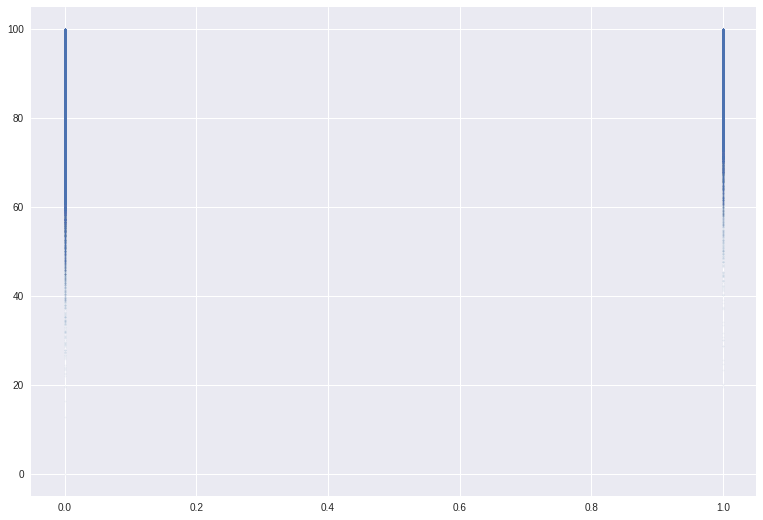

            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: employment_rate
No. Observations: 374652  Method:             REML           
No. Groups:       127806  Scale:              12.3863        
Min. group size:  1       Likelihood:         -1165240.3561  
Max. group size:  3       Converged:          Yes            
Mean group size:  2.9                                        
-------------------------------------------------------------
                 Coef.  Std.Err.    z     P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept        90.403    0.023 3907.552 0.000 90.358 90.449
gain_fiber_cable  1.135    0.038   29.545 0.000  1.060  1.210
groups RE        49.684    0.075                             

prop_educ_college_educ


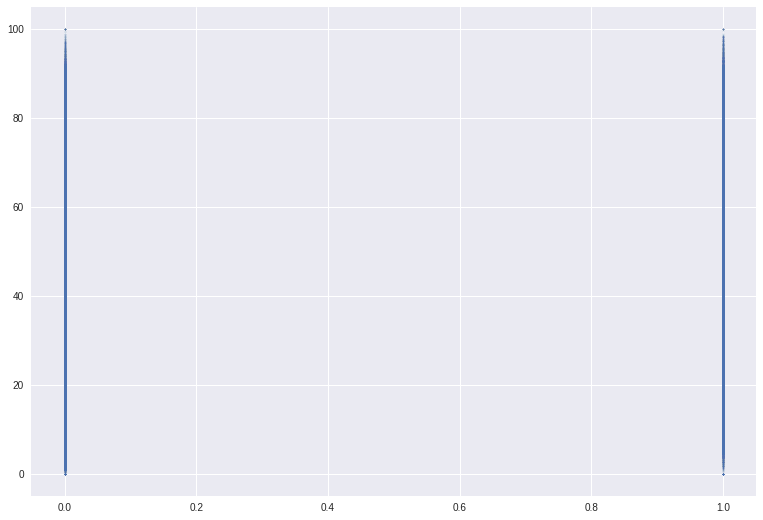

In [0]:
for args in args_list:    
    df = pd.read_gbq(query_temp.format(args[0], args[1]), project_id='fccdsicapstone-218522', dialect='standard')
    df = preprocess(df)
    df = add_binary(df, 0.3)
    for var in list_var:    
        print(var)
        viz(df, var, "gain_fiber_cable", var in list_log)
        model = mix_model(df, var, "gain_fiber_cable")
        print(model.summary())

### Update

In [15]:
def preprocess(df):
    """ Preprocess the Data, making the data in percentage"""
    df = df[df["median_household_income_in_the_past_12_months"].notnull()]
    df = df[df["unemployment_rate"].notnull()]
    for var in list_log:
        df["log({})".format(var)] = np.log(df[var])
        
    return df
    

def viz(df, var, indep_var, log):  # TODO: Add titile and axis info
    """ Visualize perc_tech50_avail with a dependent variable
    
    Params:
        df (dataframe)
        var (str): name of the dependent variable
        indep_var (str): name of the independent variable
        log (bool): whether to use log(var)
    """    
    plt.figure(figsize=(13,9))
    if not log:        
        plt.scatter(df[indep_var], df[var], s=2, alpha=0.05)
        plt.show()
    else:
        df["log_"+var] = np.log(df[var])
        plt.scatter(df[indep_var], df["log_"+var], s=2, alpha=0.05)
        plt.show()
        

def mix_model(df, var):
    """ Fit a linear mixed model: var ~ perc_urban + elevation_mean + road_density +
                     prop_white + prop_black+  prop_hisp + prop_educ_min_hs
                   + prop_educ_college_educ  + unemployment_rate + prop_home_owners + population_density + log(median_household_income)
    
    Params:
        df (dataframe)
        var (str): name of the dependent variable  
        indep_var (str): name of the independent variable
    """
    md = smf.mixedlm(var+"""~ perc_tech50_avail""",
                 df,
                 groups=df["block_group_code"])
    mdf = md.fit()
    return mdf 

In [3]:
list_var = [
    "perc_urban",
    "elevation_mean",
    "road_density",
    "prop_white",
    "prop_black",
    "prop_hisp",
    "prop_educ_min_hs",
    "prop_educ_college_educ",
    "prop_home_owners",
    "population_density"
    "median_home_value",
    "median_household_income_in_the_past_12_months",
    "unemployment_rate",
    "perc_tech50_avail"
]


list_log = [
    "median_household_income_in_the_past_12_months",
    "median_home_value"
]

In [4]:
for i in list_var:
    print(i, end=", ")

perc_urban, elevation_mean, road_density, prop_white, prop_black, prop_hisp, prop_educ_min_hs, prop_educ_college_educ, prop_home_owners, population_densitymedian_home_value, median_household_income_in_the_past_12_months, unemployment_rate, perc_tech50_avail, 

In [20]:
query_temp = """
SELECT block_group_code, median_home_value,  unemployment_rate, perc_tech50_avail
FROM broadband.fcc_acs_with_geo_and_props_2014_table
WHERE median_home_value > 0 AND perc_urban {0}

UNION ALL

SELECT block_group_code, median_home_value,  unemployment_rate, perc_tech50_avail
FROM broadband.fcc_acs_with_geo_and_props_2015_table
WHERE median_home_value > 0 AND perc_urban {0}

UNION ALL

SELECT block_group_code, median_home_value,  unemployment_rate, perc_tech50_avail
FROM broadband.fcc_acs_with_geo_and_props_2016_table
WHERE median_home_value > 0 AND perc_urban {0}
"""

df = pd.read_gbq(query_temp.format(">= 0.8"), project_id='fccdsicapstone-218522', dialect='standard')


In [9]:
df = df[df["median_household_income_in_the_past_12_months"].notnull()]
df = df[df["unemployment_rate"].notnull()]


In [11]:
df = preprocess(df)

AttributeError: 'float' object has no attribute 'log'

In [10]:
df.isnull().any()

block_group_code                                 False
perc_urban                                       False
elevation_mean                                   False
road_density                                     False
prop_white                                       False
prop_black                                       False
prop_hisp                                        False
prop_educ_min_hs                                 False
prop_educ_college_educ                           False
prop_home_owners                                 False
population_density                               False
median_home_value                                False
median_household_income_in_the_past_12_months    False
unemployment_rate                                False
perc_tech50_avail                                False
dtype: bool

In [21]:
md = smf.mixedlm("median_home_value"+"~ perc_tech50_avail", df, groups=df["block_group_code"])
mdf = md.fit()

In [22]:
mdf.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Mixed Linear Model Regression Results
==============================================================================
Model:                 MixedLM      Dependent Variable:      median_home_value
No. Observations:      436996       Method:                  REML             
No. Groups:            149010       Scale:                   2293671509.5138  
Min. group size:       1            Likelihood:              -5633479.0449    
Max. group size:       3            Converged:               Yes              
Mean group size:       2.9                                                    
------------------------------------------------------------------------------
                       Coef.      Std.Err.    z    P>|z|   [0.025     0.975]  
------------------------------------------------------------------------------
Intercept              237699.873  578.249 411.068 0.000 236566.526 238833.220
perc_tech50_avail       38674.925  653.474  59.184 0.000  37394.140  39955.711
Group Var         45949597039.173 4429.321                                    
==============================================================================

"""